In [1]:
import cv2
import numpy as np
import glob
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from scipy.ndimage import median_filter

In [2]:
# Define the base directory path for the training dataset
train_path = '/Users/liqi/Desktop/23AUTUMNSEM/FYP/Original_dataset/train'

In [3]:
# Initialize lists to store the images and labels
images = []
labels = []

In [4]:
def preprocess_image(image_path, target_size=(64,64)):
    # Attempt to read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Check if the image was not read properly
    if image is None:
        raise ValueError(f"Error reading image. Make sure the file exists and is an image: {image_path}")
    
    # Resize the image
    image_resized = cv2.resize(image, target_size)
    
    # Normalize the pixel values to the range [0, 1]
    image_normalized = image_resized.astype('float32') / 255.0
    return image_normalized

In [5]:
# Function to get label from folder name
def get_label_from_folder_name(folder_name):
    return folder_name

In [6]:
def plot_loss_and_accuracy_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
def process_images(image_paths, images, labels):
    for image_path in image_paths:
        try:
            processed_image = preprocess_image(image_path)
            # Check for missing or invalid data
            if processed_image is not None and label is not None:
                images.append(processed_image)
                labels.append(label)
            else:
                print(f"Skipped invalid data for image: {image_path}")
        except ValueError as e:
            print(f"Error processing image: {image_path}, {e}")

# Iterate over each character's folder in train_path
for character_folder in os.listdir(train_path):
    # Skip any files, looking for directories
    if not os.path.isdir(os.path.join(train_path, character_folder)):
        continue
    
    # Full path to the character's folder
    character_folder_path = os.path.join(train_path, character_folder)
    
    # Get all image paths for this character
    image_paths = glob.glob(os.path.join(character_folder_path, '*.png'))
    
    # Get the label for this character
    label = get_label_from_folder_name(character_folder)
    
    # Process images and add them to the train dataset
    process_images(image_paths, images, labels)


In [8]:
# Convert lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

In [9]:
# Split the data before augmentation to keep validation set untouched by augmentation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [10]:
# Print out the shapes of the resulting arrays as a basic check
print((X_train.shape, y_train.shape), (X_val.shape, y_val.shape))

((718206, 64, 64), (718206,)) ((179552, 64, 64), (179552,))


In [11]:
# Use LabelEncoder and convert labels to categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [12]:
unique_train_labels = np.unique(y_train_encoded)
unique_val_labels = np.unique(y_val_encoded)
print("Unique label values in y_train_encoded:", unique_train_labels)
print("Unique label values in y_val_encoded:", unique_val_labels)

Unique label values in y_train_encoded: [   0    1    2 ... 3752 3753 3754]
Unique label values in y_val_encoded: [   0    1    2 ... 3752 3753 3754]


In [12]:
# Print out the shapes of the resulting arrays as a basic check
print((X_train.shape, y_train_encoded.shape), (X_val.shape, y_val_encoded.shape))

((718206, 64, 64), (718206,)) ((179552, 64, 64), (179552,))


In [13]:
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
X_val = X_val.reshape(-1, X_val.shape[1], X_val.shape[2], 1)

In [15]:
print((X_train.shape, y_train.shape), (X_val.shape, y_val.shape))

((718206, 64, 64, 1), (718206,)) ((179552, 64, 64, 1), (179552,))


In [14]:
# define a image data generator
datagen = ImageDataGenerator(
         width_shift_range=0.01, # horizontal shift
         height_shift_range=0.01, # vertical shift
         shear_range=0.1, # shear angle in counter-clockwise direction in degrees
         zoom_range=0.1, # zoom
)
# flow data generator
train_generator = datagen.flow(X_train, y_train_encoded, batch_size=32, shuffle=False)
test_generator = datagen.flow(X_val, y_val_encoded, batch_size=32, shuffle=False)

In [17]:
print(f'Processed {len(images)} images with {len(np.unique(labels))} unique labels.')

Processed 897758 images with 3755 unique labels.


CNN model

In [14]:
class CustomCNN(models.Model):
    def __init__(self, number_of_characters=20):
        super(CustomCNN, self).__init__()
        # Convolutional Layer 1
        self.conv1 = layers.Conv2D(6, (3, 3), activation='relu', padding='same')
        # Pooling Layer 1
        self.pool1 = layers.MaxPooling2D((2, 2))
        # Convolutional Layer 2
        self.conv2 = layers.Conv2D(12, (3, 3), activation='relu', padding='same')
        # Pooling Layer 2
        self.pool2 = layers.MaxPooling2D((2, 2))
        # Fully Connected Layer
        self.flatten = layers.Flatten()
        # Dense layer with number_of_characters units for classification
        self.dense = layers.Dense(number_of_characters, activation='softmax')

    # Define the forward pass
    def call(self, inputs):
        # Chain all the layers together
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        # Return the output of the fully connected layer
        return self.dense(x)

# Assuming input image size of 28x28 and grayscale (1 channel), adjust if different
input_shape = (64, 64, 1)

# Instantiate the model
model = CustomCNN(number_of_characters=len(label_encoder.classes_))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.build(input_shape=(None, *input_shape))
print(model.summary())

Model: "custom_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  60        
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           multiple                  660       
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  1

In [15]:
# early stopping and reduce learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
# Train the model
history_cnn = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=1000,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000
22443/22443 [==============================] - 1198s 53ms/step - loss: 5.4115 - accuracy: 0.1925 - val_loss: 2.9955 - val_accuracy: 0.4212 - lr: 0.0010
Epoch 2/1000
22443/22443 [==============================] - 1166s 52ms/step - loss: 2.3552 - accuracy: 0.5260 - val_loss: 2.2817 - val_accuracy: 0.5394 - lr: 0.0010
Epoch 3/1000
22443/22443 [==============================] - 1198s 53ms/step - loss: 1.8336 - accuracy: 0.6178 - val_loss: 2.0815 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 4/1000
22443/22443 [==============================] - 1171s 52ms/step - loss: 1.5743 - accuracy: 0.6651 - val_loss: 1.9228 - val_accuracy: 0.5993 - lr: 0.0010
Epoch 5/1000
22443/22443 [==============================] - 1126s 50ms/step - loss: 1.3977 - accuracy: 0.6973 - val_loss: 1.8504 - val_accuracy: 0.6115 - lr: 0.0010
Epoch 6/1000
22443/22443 [==============================] - 1046s 47ms/step - loss: 1.2419 - accuracy: 0.7274 - val_loss: 1.7637 - val_accuracy: 0.6251 - lr: 0.0010
Epoch 7/10

5611/5611 [==============================] - 52s 9ms/step - loss: 1.7304 - accuracy: 0.6393
Test Loss: 1.7303780317306519
Test Accuracy: 63.93%


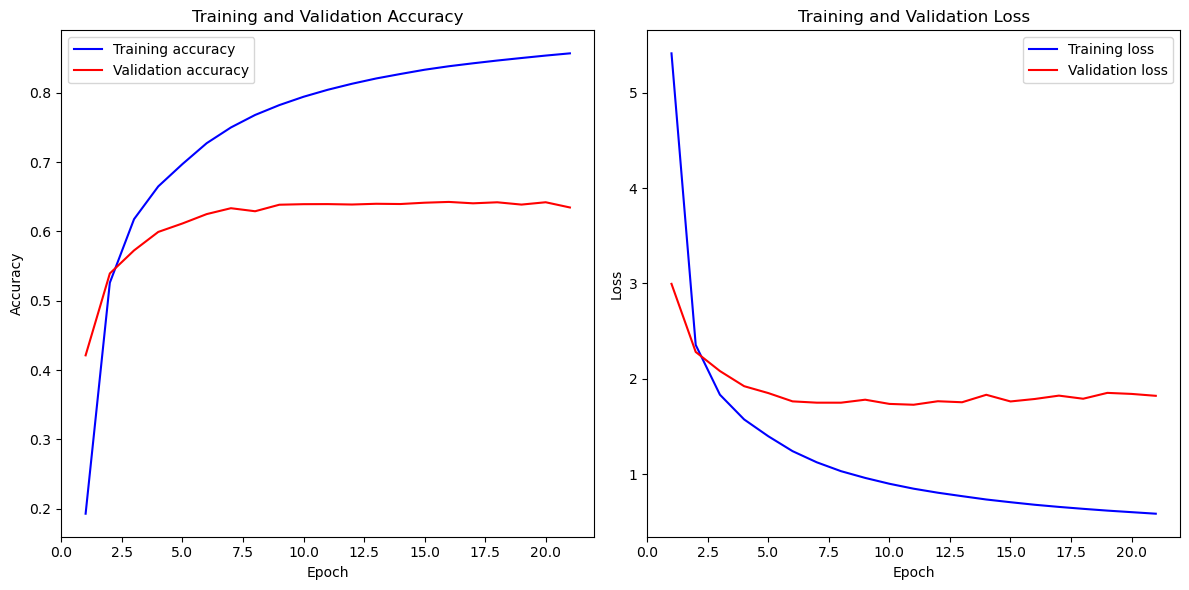

In [16]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
# Print the test loss and accuracy
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
# show the loss and accuracy curves
plot_loss_and_accuracy_curves(history_cnn)

In [18]:
# predict the validation set
y_pred = model.predict(X_val)
# get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)
# get the confusion matrix
conf_matrix = confusion_matrix(y_val_encoded, y_pred_labels)
# print the confusion matrix
print(classification_report(y_val_encoded, y_pred_labels))

5611/5611 [==============================] - 39s 7ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.78      0.80      0.79        49
           2       0.77      0.66      0.71        41
           3       0.60      0.48      0.53        44
           4       0.66      0.73      0.69        51
           5       0.90      0.88      0.89        52
           6       0.89      0.81      0.85        48
           7       0.88      0.76      0.82        55
           8       0.81      0.78      0.79        59
           9       0.81      0.48      0.60        46
          10       0.77      0.73      0.75        41
          11       0.85      0.54      0.66        54
          12       0.64      0.73      0.68        41
          13       0.84      0.52      0.64        52
          14       0.58      0.57      0.57        44
          15       0.61      0.66      0.63        47
          16       0.88

In [ ]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn')

Increase the stride to reduce the overlapping

In [149]:
class CNN2(models.Model):
    def __init__(self, number_of_characters=20):
        super(CNN2, self).__init__()
        # Convolutional Layer 1
        self.conv1 = layers.Conv2D(6, (3, 3), strides=(2, 2), activation='relu', padding='same')
        # Pooling Layer 1
        self.pool1 = layers.MaxPooling2D((2, 2))
        # Convolutional Layer 2
        self.conv2 = layers.Conv2D(12, (3, 3), strides=(2, 2), activation='relu', padding='same')
        # Pooling Layer 2
        self.pool2 = layers.MaxPooling2D((2, 2))
        # Fully Connected Layer
        self.flatten = layers.Flatten()
        # Dense layer with number_of_characters units for classification
        self.dense = layers.Dense(number_of_characters, activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        return self.dense(x)

In [150]:
# Assuming input image size of 28x28 and grayscale (1 channel), adjust if different
input_shape = (64, 64, 1)

# Instantiate the model
model = CNN2(number_of_characters=len(label_encoder.classes_))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [151]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history_cnn2 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=1000,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000
22443/22443 [==============================] - 186s 8ms/step - loss: 6.6372 - accuracy: 0.0419 - val_loss: 5.7999 - val_accuracy: 0.0838 - lr: 0.0010
Epoch 2/1000
22443/22443 [==============================] - 180s 8ms/step - loss: 5.2115 - accuracy: 0.1313 - val_loss: 4.8506 - val_accuracy: 0.1608 - lr: 0.0010
Epoch 3/1000
22443/22443 [==============================] - 180s 8ms/step - loss: 4.5341 - accuracy: 0.1939 - val_loss: 4.4349 - val_accuracy: 0.2013 - lr: 0.0010
Epoch 4/1000
22443/22443 [==============================] - 182s 8ms/step - loss: 4.2692 - accuracy: 0.2210 - val_loss: 4.2532 - val_accuracy: 0.2236 - lr: 0.0010
Epoch 5/1000
22443/22443 [==============================] - 177s 8ms/step - loss: 4.1401 - accuracy: 0.2349 - val_loss: 4.1602 - val_accuracy: 0.2327 - lr: 0.0010
Epoch 6/1000
22443/22443 [==============================] - 177s 8ms/step - loss: 4.0529 - accuracy: 0.2454 - val_loss: 4.0859 - val_accuracy: 0.2406 - lr: 0.0010
Epoch 7/1000
22443/224

5611/5611 [==============================] - 32s 6ms/step - loss: 2.4072 - accuracy: 0.4880
Test Loss: 2.4071879386901855
Test Accuracy: 48.80%


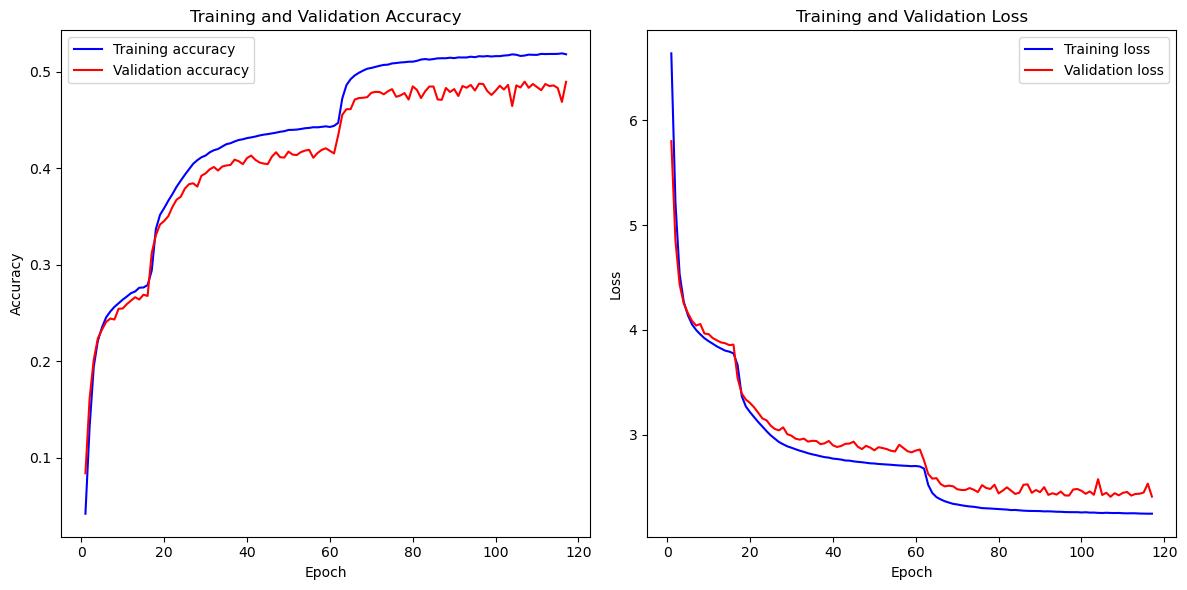

In [152]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

plot_loss_and_accuracy_curves(history_cnn2)

In [ ]:
# Save the model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn2')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn2/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn2/assets


Add midian filter to images

In [19]:
# Define a function to apply median filter to an image
def apply_median_filter(image):
    filtered_image = median_filter(image, size=3)
    return filtered_image
# apply the median filter to the images
train_generator = ImageDataGenerator(preprocessing_function=apply_median_filter).flow(X_train, y_train_encoded)
test_generator = ImageDataGenerator(preprocessing_function=apply_median_filter).flow(X_val, y_val_encoded)

In [18]:
# Define the early stopping and reduce learning rate callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Load the saved model
model = load_model('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn')

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model on the training data
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train) // 32,
                    epochs=1000,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/1000
22443/22443 [==============================] - 940s 42ms/step - loss: 0.4579 - accuracy: 0.8899 - val_loss: 1.5360 - val_accuracy: 0.6806 - lr: 0.0010
Epoch 2/1000
22443/22443 [==============================] - 740s 33ms/step - loss: 0.2509 - accuracy: 0.9435 - val_loss: 1.8244 - val_accuracy: 0.6729 - lr: 0.0010
Epoch 3/1000
22443/22443 [==============================] - 795s 35ms/step - loss: 0.1311 - accuracy: 0.9726 - val_loss: 2.0869 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 4/1000
22443/22443 [==============================] - 721s 32ms/step - loss: 0.0649 - accuracy: 0.9875 - val_loss: 2.4495 - val_accuracy: 0.6608 - lr: 0.0010
Epoch 5/1000
22443/22443 [==============================] - 877s 39ms/step - loss: 0.0336 - accuracy: 0.9944 - val_loss: 2.8668 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 6/1000
22443/22443 [==============================] - 661s 29ms/step - loss: 0.0213 - accuracy: 0.9972 - val_loss: 3.0207 - val_accuracy: 0.6557 - lr: 0.0010
Epoch 7/1000
224

5611/5611 [==============================] - 68s 12ms/step - loss: 1.5360 - accuracy: 0.6806
Test Loss: 1.535983681678772
Test Accuracy: 68.06%


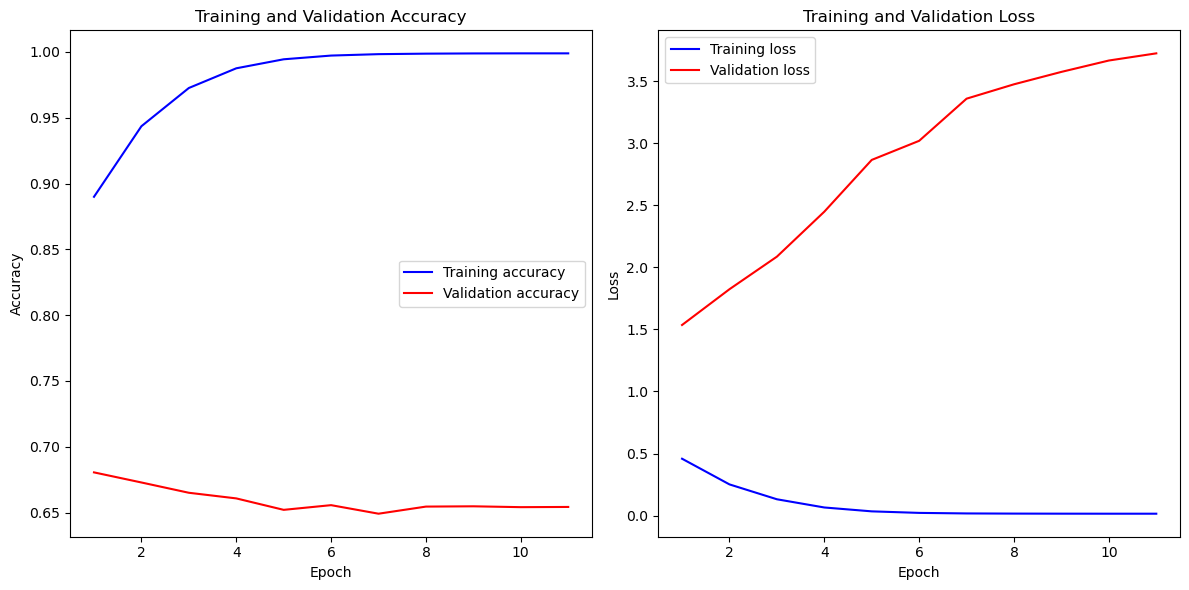

In [19]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
plot_loss_and_accuracy_curves(history)

In [24]:
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_val_encoded, y_pred_labels)

5611/5611 [==============================] - 95s 17ms/step


In [32]:
print(classification_report(y_val_encoded, y_pred_labels))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        42
           1       0.79      0.84      0.81        49
           2       0.61      0.66      0.64        41
           3       0.74      0.39      0.51        44
           4       0.59      0.84      0.69        51
           5       0.85      0.88      0.87        52
           6       0.94      0.69      0.80        48
           7       0.84      0.69      0.76        55
           8       0.86      0.81      0.83        59
           9       0.72      0.57      0.63        46
          10       0.78      0.68      0.73        41
          11       0.83      0.63      0.72        54
          12       0.69      0.54      0.60        41
          13       0.70      0.73      0.72        52
          14       0.70      0.59      0.64        44
          15       0.75      0.45      0.56        47
          16       0.70      0.84      0.76        38
          17       0.88    

In [ ]:
# Save the updated model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated/assets


improve of model

In [39]:
# Define a CNN model with more layers
class CustomCNN_2(models.Model):
    def __init__(self, number_of_characters=20):
        super(CustomCNN_2, self).__init__()
        # Convolutional Layer 1
        self.conv1 = layers.Conv2D(6, (5, 5), activation='relu', padding='same')
        self.bn1 = layers.BatchNormalization()
        # Pooling Layer 1
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)

        # Convolutional Layer 2
        self.conv2 = layers.Conv2D(12, (3, 3), activation='relu', padding='same')
        self.bn2 = layers.BatchNormalization()
        # Pooling Layer 2
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.2)

        # Convolutional Layer 3
        self.conv3 = layers.Conv2D(24, (3, 3), activation='relu', padding='same')
        self.bn3 = layers.BatchNormalization()
        # Pooling Layer 3
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)

        # Fully Connected Layer
        self.flatten = layers.Flatten()
        # Dense layer with number_of_characters units for classification
        self.dense3 = layers.Dense(number_of_characters, activation='softmax')

    # Define the forward pass
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.flatten(x)

        # Return the output of the fully connected layer
        return self.dense3(x)


# input image size of 28x28 and grayscale (1 channel), adjust if different
input_shape = (64, 64, 1)

# Instantiate the model
model = CustomCNN_2(number_of_characters=len(label_encoder.classes_))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.build(input_shape=(None, *input_shape))
print(model.summary())

Model: "custom_cnn_2_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          multiple                  156       
                                                                 
 batch_normalization_9 (Bat  multiple                  24        
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 dropout_30 (Dropout)        multiple                  0         
                                                                 
 conv2d_39 (Conv2D)          multiple                  660       
                                                                 
 batch_normalization_10 (Ba  multiple              

In [40]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history_improve_cnn = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=1000,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000
22443/22443 [==============================] - 678s 30ms/step - loss: 2.6405 - accuracy: 0.4834 - val_loss: 1.4882 - val_accuracy: 0.6611 - lr: 0.0010
Epoch 2/1000
22443/22443 [==============================] - 660s 29ms/step - loss: 1.3272 - accuracy: 0.6890 - val_loss: 1.7449 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 3/1000
22443/22443 [==============================] - 668s 30ms/step - loss: 1.0653 - accuracy: 0.7422 - val_loss: 1.1314 - val_accuracy: 0.7336 - lr: 0.0010
Epoch 4/1000
22443/22443 [==============================] - 662s 29ms/step - loss: 0.9232 - accuracy: 0.7711 - val_loss: 1.3621 - val_accuracy: 0.6907 - lr: 0.0010
Epoch 5/1000
22443/22443 [==============================] - 662s 29ms/step - loss: 0.8310 - accuracy: 0.7903 - val_loss: 1.0284 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 6/1000
22443/22443 [==============================] - 662s 30ms/step - loss: 0.7659 - accuracy: 0.8035 - val_loss: 1.0573 - val_accuracy: 0.7489 - lr: 0.0010
Epoch 7/1000
224

5611/5611 [==============================] - 64s 11ms/step - loss: 1.0284 - accuracy: 0.7559
Test Loss: 1.0283708572387695
Test Accuracy: 75.59%


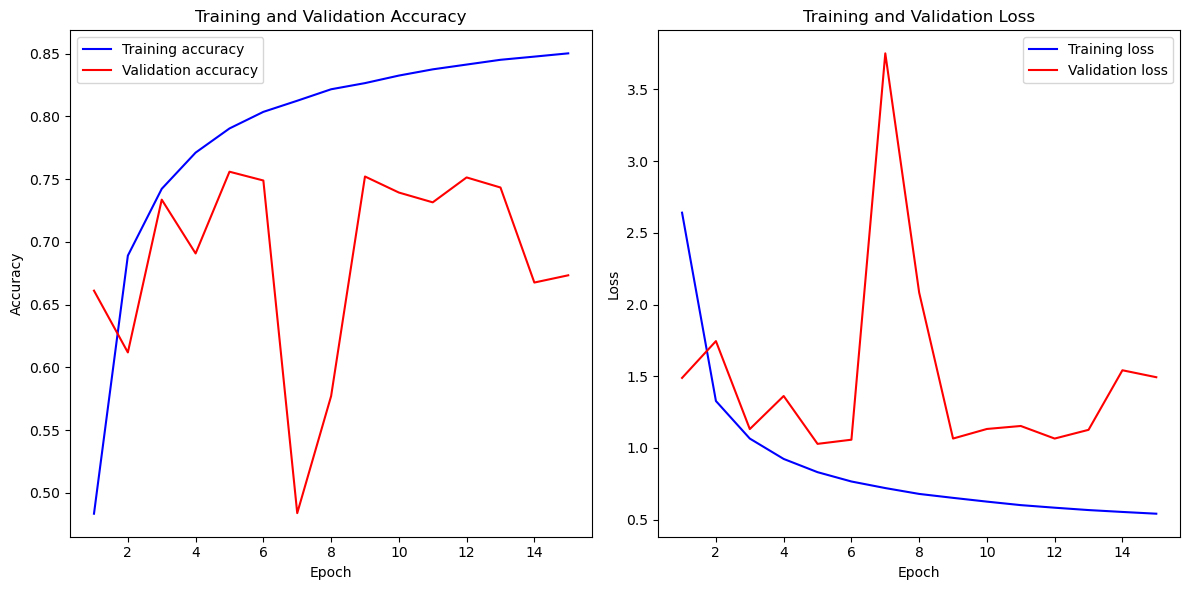

In [41]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')
plot_loss_and_accuracy_curves(history_improve_cnn)

In [42]:
# Assuming y_true is already integer labels
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_val_encoded, y_pred_labels)
print(classification_report(y_val_encoded, y_pred_labels))

5611/5611 [==============================] - 34s 6ms/step
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        42
           1       0.79      0.86      0.82        49
           2       0.76      0.85      0.80        41
           3       0.77      0.55      0.64        44
           4       0.69      0.73      0.70        51
           5       0.81      0.88      0.84        52
           6       0.66      0.96      0.78        48
           7       0.84      0.78      0.81        55
           8       0.78      0.92      0.84        59
           9       0.78      0.76      0.77        46
          10       0.79      0.80      0.80        41
          11       0.91      0.78      0.84        54
          12       0.58      0.68      0.63        41
          13       0.90      0.67      0.77        52
          14       0.68      0.73      0.70        44
          15       0.77      0.64      0.70        47
          16       0.60

In [43]:
# Save the updated model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated2')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated2/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated2/assets


Add one more layer

In [45]:
# Define a CNN model with more layers
class CustomCNN_3(models.Model):
    def __init__(self, number_of_characters=20):
        super(CustomCNN_3, self).__init__()
        # Convolutional Layer 1
        self.conv1 = layers.Conv2D(6, (5, 5), activation='relu', padding='same')
        self.bn1 = layers.BatchNormalization()
        # Pooling Layer 1
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)

        # Convolutional Layer 2
        self.conv2 = layers.Conv2D(12, (3, 3), activation='relu', padding='same')
        self.bn2 = layers.BatchNormalization()
        # Pooling Layer 2
        self.pool2 = layers.MaxPooling2D((2, 2))
        self.dropout2 = layers.Dropout(0.2)

        # Convolutional Layer 3
        self.conv3 = layers.Conv2D(24, (3, 3), activation='relu', padding='same')
        self.bn3 = layers.BatchNormalization()
        # Pooling Layer 3
        self.pool3 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)

        # Convolutional Layer 4
        self.conv4 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')
        self.bn4 = layers.BatchNormalization()
        # Pooling Layer 4
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout4 = layers.Dropout(0.2)

        # Fully Connected Layer
        self.flatten = layers.Flatten()
        # Dense layer with number_of_characters units for classification
        self.dense3 = layers.Dense(number_of_characters, activation='softmax')

    # Define the forward pass
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.dropout4(x)

        x = self.flatten(x)

        # Return the output of the fully connected layer
        return self.dense3(x)


# input image size of 28x28 and grayscale (1 channel), adjust if different
input_shape = (64, 64, 1)

# Instantiate the model
model = CustomCNN_3(number_of_characters=len(label_encoder.classes_))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.build(input_shape=(None, *input_shape))
print(model.summary())

Model: "custom_cnn_3_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          multiple                  156       
                                                                 
 batch_normalization_16 (Ba  multiple                  24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_45 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 conv2d_46 (Conv2D)          multiple                  660       
                                                                 
 batch_normalization_17 (Ba  multiple               

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

history_improve_cnn2 = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,
    epochs=1000,
    validation_data=test_generator,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/1000
22443/22443 [==============================] - 611s 27ms/step - loss: 2.5937 - accuracy: 0.4815 - val_loss: 1.4156 - val_accuracy: 0.6695 - lr: 0.0010
Epoch 2/1000
22443/22443 [==============================] - 606s 27ms/step - loss: 1.3395 - accuracy: 0.6781 - val_loss: 1.7041 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 3/1000
22443/22443 [==============================] - 608s 27ms/step - loss: 1.1391 - accuracy: 0.7199 - val_loss: 1.0724 - val_accuracy: 0.7408 - lr: 0.0010
Epoch 4/1000
22443/22443 [==============================] - 604s 27ms/step - loss: 1.0335 - accuracy: 0.7419 - val_loss: 0.9311 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 5/1000
22443/22443 [==============================] - 611s 27ms/step - loss: 0.9693 - accuracy: 0.7557 - val_loss: 0.8070 - val_accuracy: 0.7991 - lr: 0.0010
Epoch 6/1000
22443/22443 [==============================] - 607s 27ms/step - loss: 0.9238 - accuracy: 0.7658 - val_loss: 0.8313 - val_accuracy: 0.7943 - lr: 0.0010
Epoch 7/1000
224

In [47]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc * 100:.2f}%')

5611/5611 [==============================] - 67s 12ms/step - loss: 0.6872 - accuracy: 0.8270
Test Loss: 0.6872409582138062
Test Accuracy: 82.70%


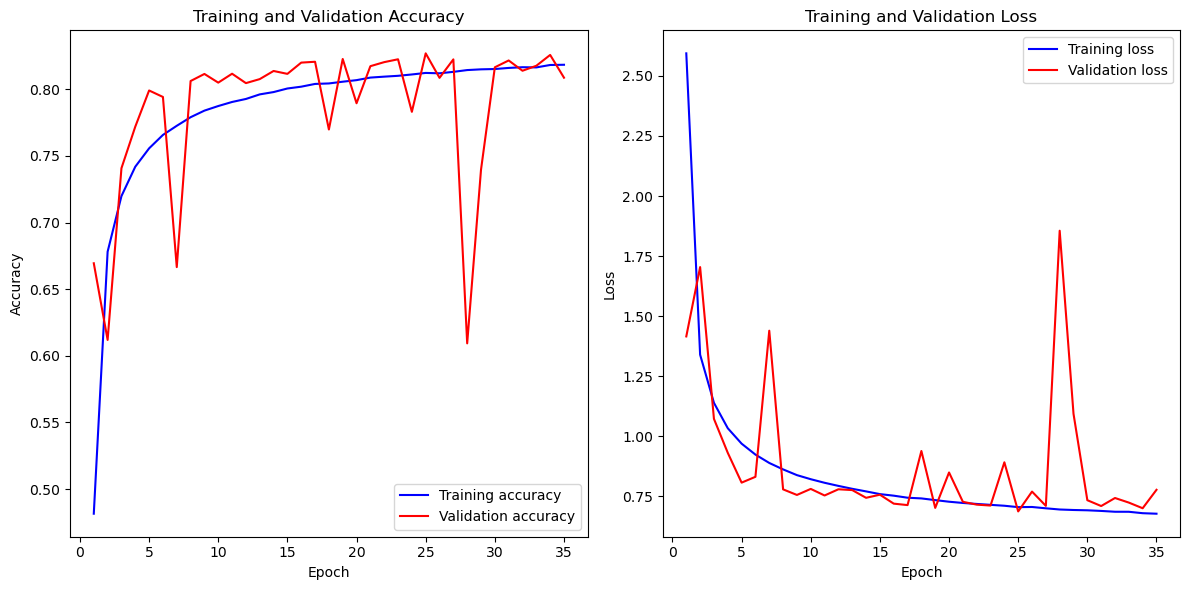

5611/5611 [==============================] - 37s 7ms/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83        42
           1       0.76      0.96      0.85        49
           2       0.80      0.90      0.85        41
           3       0.73      0.73      0.73        44
           4       0.95      0.82      0.88        51
           5       0.96      0.83      0.89        52
           6       0.78      0.90      0.83        48
           7       0.88      0.89      0.88        55
           8       0.87      0.93      0.90        59
           9       0.64      0.85      0.73        46
          10       0.97      0.88      0.92        41
          11       0.80      0.87      0.83        54
          12       0.74      0.90      0.81        41
          13       0.94      0.94      0.94        52
          14       0.96      0.61      0.75        44
          15       0.78      0.83      0.80        47
          16       0.74

In [48]:
plot_loss_and_accuracy_curves(history_improve_cnn2)
# Assuming y_true is already integer labels
y_pred = model.predict(X_val)
y_pred_labels = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_val_encoded, y_pred_labels)
print(classification_report(y_val_encoded, y_pred_labels))

In [49]:
# Save the updated model
model.save('/Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated3')

INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated3/assets


INFO:tensorflow:Assets written to: /Users/liqi/Desktop/23AUTUMNSEM/FYP/chinese_cnn_updated3/assets
